# BMED 6780 Programming Practical II

## Deep Classifier and Performance Metrics: MedNIST

### a1. Load the Data: Display 10 random images with their associated labels


In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import imageio.v2 as imageio
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image

C:\Users\sinad\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


!pip uninstall torchvision

In [3]:
pwd

'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6780 - Med Image Processing\\Programming Practicals\\Practical 2\\Practical_2'

In [5]:
cd ..

C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6780 - Med Image Processing\Programming Practicals\Practical 2


In [7]:
# Load the data:
directory = 'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6780 - Med Image Processing\\Programming Practicals\\Practical 2\\MedNIST'
dir_path = os.path.abspath(directory)
print("The MedNIST path is: ", dir_path)

The MedNIST path is:  C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6780 - Med Image Processing\Programming Practicals\Practical 2\MedNIST


In [85]:
# List to store image file paths
image_files = []

# List to store labels
labels = []

# Loop through subfolders
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Print the number of image files and labels
print("Number of image files:", len(image_files))
print("Number of labels:", len(labels))

Number of image files: 58954
Number of labels: 58954


In [10]:
print(image_files[0:1])

['C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6780 - Med Image Processing\\Programming Practicals\\Practical 2\\MedNIST\\AbdomenCT\\000000.jpeg']


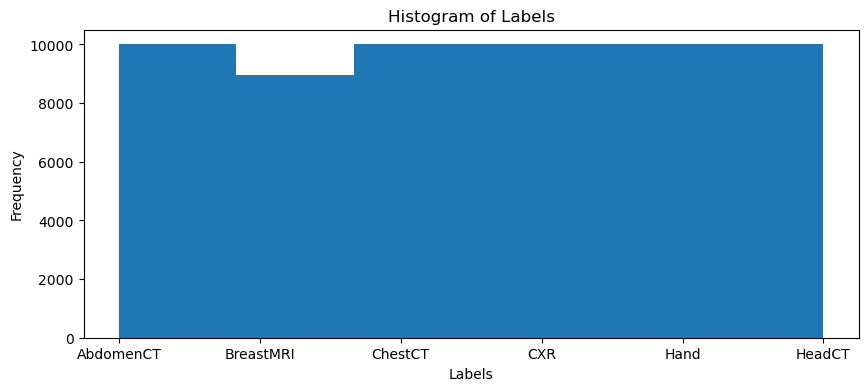

In [13]:
# Plot histogram of labels
plt.figure(figsize=(10, 4))
plt.hist(labels, bins=6)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

In [15]:
# Check for imbalance
unique_labels = set(labels)
label_counts = {label: labels.count(label) for label in unique_labels}
print("Label Counts:", label_counts)

Label Counts: {'ChestCT': 10000, 'Hand': 10000, 'AbdomenCT': 10000, 'BreastMRI': 8954, 'HeadCT': 10000, 'CXR': 10000}


000000.jpeg
(64, 64)
000000.jpeg
(64, 64)
000000.jpeg
(64, 64)
000000.jpeg
(64, 64)
000000.jpeg
(64, 64)
000000.jpeg
(64, 64)


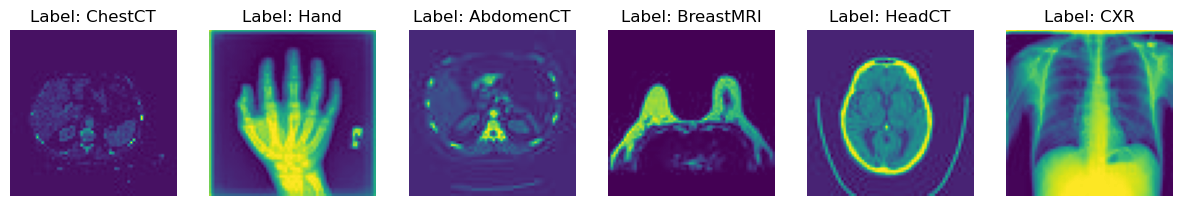

In [101]:
# Display an image from each label
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels):
    plt.subplot(1, 6, i+1)
    image_path = os.path.join(dir_path, [filename for filename in image_files if label in filename][0])
    print(image_path.split(sep="\\")[-1])
    img = imageio.imread(image_path)
    print(np.shape(img))
    plt.imshow(img)
    plt.title('Label: ' + label)
    plt.axis('off')
plt.show()

### a.2 We need to convert the JPEG images into tensors to resize every image to the range of [0 to 1] by dividing the maximumimage intensity value.
### a.3: After rescaling, please randomly split the dataset into train, validation and test set with a reasonable split ratio (e.g., train:validation:test=7:2:1).

In [30]:
batch_size = 16

In [87]:
print(np.shape(image_files), len(labels))

(58954,) 58954


In [89]:
# Assuming you have a custom dataset class named MyDataset
class MyDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        assert len(self.image_files) == len(self.labels), "Lengths of image_files and labels must match"
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load and preprocess your image here
        image_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Open image using PIL
        img = Image.open(image_path)

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        # Convert image to numpy array, normalize pixel intensities to [0, 1], and convert to tensor
        img = transforms.functional.to_tensor(img)
        
        return img, label

# Create a dataset instance
dataset = MyDataset(image_files, labels)

# Define the sizes of train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances for each split
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of training samples:", len(train_set))
print("Number of validation samples:", len(val_set))
print("Number of test samples:", len(test_set))


Number of training samples: 41267
Number of validation samples: 11790
Number of test samples: 5897


### b. A convolutional neural network (CNN) that contains 2 convolutional layers. The architecture of this model is: [INPUT - CONV - RELU - MAXPOOL - CONV - RELU - MAXPOOL - FC1 - FC2 - FC3]

In [127]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # 7x7 is the spatial dimension after 2 maxpooling layers
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc1(x)
        x = self.relu1(x)  # ReLU activation for the first fully connected layer
        x = self.fc2(x)
        x = self.relu2(x)  # ReLU activation for the second fully connected layer
        x = self.fc3(x)
        return x


In [129]:
model = SimpleCNN(num_classes=6)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


### 1c: Train and Validate the Network:
- Cross-entropy loss
- Adam Optimizer
- Learning rate = 1e-3
- Batch Size = 16

In [132]:
learning_rate = 1e-3
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

from sklearn.preprocessing import LabelEncoder

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
       
        # Initialize LabelEncoder
        label_encoder = LabelEncoder()

        # Fit and transform labels to numerical values
        labels = label_encoder.fit_transform(labels)

        # Convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
from sklearn.preprocessing import LabelEncoder

train_losses = []
val_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    running_train_loss = 0.0
    running_val_loss = 0.0
    
    # Training loop
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
       
        # Initialize LabelEncoder
        label_encoder = LabelEncoder()

        # Fit and transform labels to numerical values
        labels = label_encoder.fit_transform(labels)

        # Convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            
            # Initialize LabelEncoder
            label_encoder = LabelEncoder()

            # Fit and transform labels to numerical values
            labels = label_encoder.fit_transform(labels)

            # Convert labels to tensor
            labels = torch.tensor(labels, dtype=torch.long)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(val_loader)

    # Print and store losses
    print(f'Epoch [{epoch + 1}/10], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

print('Finished Training')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Testing the network on the test dataset
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        # Move inputs and labels to the appropriate device if using GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
